In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install scGeneFit
!pip install scanpy

     |████████████████████████████████| 13.2MB 12.2MB/s 
     |████████████████████████████████| 10.2MB 11.2MB/s 
     |████████████████████████████████| 122kB 48.1MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.1-cp36-none-any.whl size=7018 sha256=99f1ff585a39b58c1cee0924c56ba93750cc550f5471289cc9230d29af017acf
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
Successfully built sinfo


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan 19 00:19:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import scanpy

In [ ]:
paul_data = scanpy.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [ ]:
labels = paul_data.obs['paul15_clusters']
data = paul_data.to_df()

In [ ]:
import sys
import os
sys.path.append(os.path.abspath('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks'))

In [ ]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks']

In [ ]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

from sklearn.ensemble import RandomForestClassifier

from scipy.stats import pearsonr

import seaborn as sns
import os
import scipy
import scipy.io

import pandas as pd

In [ ]:
#squeezefit stuff
from scGeneFit.functions import *
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

num_markers=25
method='pairwise_centers'
sampling_rate=0.05 #use 5 percent of the data to generate constraints
n_neighbors=0 #neighbors are not used for the center constraints
epsilon=10 #Delta is 10*norm of the smallest constraint
max_constraints=500 #use at most 500 constraints (for efficiency)
use_centers=True #constraints given by pairwise distances

In [ ]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


Settings

In [ ]:
z_size = 400
hidden_layer_size = 2000

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 32
lr = 0.000001
b1 = 0.9
b2 = 0.999

global_t = 4


k_range = [10, 50, 100, 250]


# turn both of these off if you just want to run analysis
buildSqueezeFitMarkers = False
buildModels = False


In [ ]:
np.random.seed(100)
slices = np.random.permutation(np.arange(data.shape[0]))
upto = int(.8 * len(data))

train_data = data.values[slices[:upto], :]
test_data = data.values[slices[upto:], :]

labels_orig = labels

paul_label_encoder = LabelEncoder()
labels2 = paul_label_encoder.fit_transform(labels)
train_labels = labels2[slices[:upto]]
test_labels = labels2[slices[upto:]]


#scaler = StandardScaler()
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
%%time

if buildSqueezeFitMarkers:
    sc_markers = get_markers_hierarchy(train_data, [train_labels], num_markers, method=method, 
                        sampling_rate=sampling_rate, n_neighbors=n_neighbors, epsilon=epsilon)
    with open('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/paul_markers.npy', 'wb') as f:
        np.save(f, sc_markers)
else:
    with open('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/paul_markers.npy', 'rb') as f:
        sc_markers = np.load(f) 
    

accuracy=performance(train_data, train_labels, test_data, test_labels, clf)
accuracy_markers=performance(train_data[:,sc_markers], train_labels, test_data[:,sc_markers], test_labels, clf)

print("Accuracy (whole data,", train_data.shape[1], " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

Accuracy (whole data, 3451  markers):  0.5128205128205128
Accuracy (selected 25 markers) 0.4597069597069597
CPU times: user 45.1 ms, sys: 10.3 ms, total: 55.4 ms
Wall time: 1.11 s


In [ ]:
train_data = Tensor(train_data).to(device)
test_data = Tensor(test_data).to(device)

In [ ]:
def top_logits_gumbel_globalgate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_GlobalGate)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = data.shape[1]).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

def top_logits_gumbel_runningstate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_RunningState)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = data.shape[1]).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

def top_logits_gumbel_concrete_vae_nsml(data, model):
    assert isinstance(model, ConcreteVAE_NMSL)
    
    with torch.no_grad():

        w = gumbel_keys(model.logit_enc, EPSILON = torch.finfo(torch.float32).eps)
        w = torch.softmax(w/model.t, dim = -1)
        subset_indices = w.clone().detach()

        #max_idx = torch.argmax(subset_indices, 1, keepdim=True)
        #one_hot = Tensor(subset_indices.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        all_subsets = subset_indices.sum(dim = 0)

        inds = torch.argsort(subset_indices.sum(dim = 0), descending = True)[:model.k]
        all_logits = torch.nn.functional.one_hot(inds, num_classes = data.shape[1]).sum(dim = 0)
        
        
        
        
    return all_logits, all_subsets

In [ ]:
def train_model(train_data, model):
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=lr, 
                                 betas = (b1,b2))
    
    
    for epoch in range(1, n_epochs+1):
        train(train_data, 
              model, 
              optimizer, 
              epoch, 
              batch_size)
        model.t = max(0.001, model.t * 0.99)

        
    return model

def save_model(base_path, model):
    # make directory
    if not os.path.exists(os.path.dirname(base_path)):
        try:
            os.makedirs(os.path.dirname(base_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise Exception("COULD NOT MAKE PATH")
    with open(base_path, 'wb') as PATH:
        torch.save(model.state_dict(), PATH)

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [ ]:
def train_save_model(train_data, model, base_path):
    train_model(train_data, model)
    if isinstance(model, VAE_Gumbel_RunningState):
        model.set_burned_in()
    save_model(base_path, model)

Train the VAE

In [ ]:
if buildModels:
    model = VAE(train_data.shape[1], hidden_layer_size, z_size, bias = True)
    model.to(device)
    # hack cause my train method above assumes t is there
    model.t = 1
    model.apply(weights_init)


    train_save_model(train_data, model, '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/vae/paul_vae_model.pt')

VAE L1

In [ ]:
if buildModels:
    model = VAE_l1_diag(train_data.shape[1], hidden_layer_size, z_size, bias = True)
    model.to(device)
    # hack cause my train method above assumes t is there
    model.t = 1
    model.apply(weights_init)


    train_save_model(train_data, model, '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/vae_l1/paul_vae_l1_model.pt')

Running State Training

In [ ]:
if buildModels:
    for k in k_range:
        model = VAE_Gumbel_RunningState(train_data.shape[1], hidden_layer_size, z_size, k = k, t = global_t, alpha = 0.97, bias = True)
        model.to(device)
        model.apply(weights_init)
        train_save_model(train_data, model, '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/runningstate_vae/paul_runningstate_vae_k={}.pt'.format(k))

Global Gate VAE

In [ ]:
if buildModels:
    for k in k_range:
        model = VAE_Gumbel_GlobalGate(train_data.shape[1], hidden_layer_size, z_size, k = k, t = global_t, bias = True)
        model.to(device)
        model.apply(weights_init)
        train_save_model(train_data, model, '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/globalgate_vae/paul_globalgate_vae_k={}.pt'.format(k))

Concrete VAE

In [ ]:
if buildModels:
    for k in k_range:
        model = ConcreteVAE_NMSL(train_data.shape[1], hidden_layer_size, z_size, k = k, t = global_t, bias = True)
        model.to(device)
        model.apply(weights_init)
        train_save_model(train_data, model, '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/concrete_vae/paul_concrete_vae_k={}.pt'.format(k))

Visualize the clusters from these indices and look at the accuracies

In [ ]:
def load_model(model_loader, input_size, hidden_size, z_size, bias, path, **kwargs):
    model = model_loader(input_size, hidden_size, z_size, bias = bias, **kwargs)
    if isinstance(model, VAE_Gumbel_RunningState):
        model.logit_enc = nn.Parameter(torch.zeros(input_size).view(1,-1))
    model.load_state_dict(torch.load(path))
    model.eval()
    model.to(device)
    return model

In [ ]:
def average_cosine_angle(d1, d2):
    dotprod = torch.sum(d1*d2, dim = 1)
    lengths1 = torch.norm(d1, dim = 1)
    lengths2 = torch.norm(d2, dim = 1)

    # to handle when a vector is all 0
    markers1 = lengths1 == 0
    markers2 = lengths2 == 0
    lengths1[markers1] = 1
    lengths2[markers2] =1

    return torch.mean(dotprod / (lengths1 * lengths2))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# balanced accuracy per k
# accuracy per k
# return both train and test
# with markers and without


def metrics_model(train_data, train_labels, test_data, test_labels, markers, model, k = None):
    # if model is none don't do a confusion matrix for the model with markers

    classifier_orig = RandomForestClassifier(n_jobs = -1)
    classifier_orig_markers = RandomForestClassifier(n_jobs = -1)

    classifier_orig.fit(train_data.cpu(), train_labels)
    classifier_orig_markers.fit(train_data[:,markers].cpu(), train_labels)
    

    classifier_recon = RandomForestClassifier(n_jobs = -1)
    classifier_recon_markers = RandomForestClassifier(n_jobs = -1)

    with torch.no_grad():
        train_data_recon = model(train_data)[0].cpu()
        classifier_recon.fit(train_data_recon, train_labels)
        classifier_recon_markers.fit(train_data_recon[:, markers], train_labels)


        bac_orig = balanced_accuracy_score(test_labels, classifier_orig.predict(test_data.cpu()))
        bac_orig_markers = balanced_accuracy_score(test_labels, classifier_orig_markers.predict(test_data[:, markers].cpu()))
        bac_recon = balanced_accuracy_score(test_labels, classifier_recon.predict(model(test_data)[0].cpu()))
        bac_recon_markers = balanced_accuracy_score(test_labels, classifier_recon_markers.predict(model(test_data)[0][:,markers].cpu()))

        accuracy_orig = accuracy_score(test_labels, classifier_orig.predict(test_data.cpu()))
        accuracy_orig_markers = accuracy_score(test_labels, classifier_orig_markers.predict(test_data[:, markers].cpu()))
        accuracy_recon = accuracy_score(test_labels, classifier_recon.predict(model(test_data)[0].cpu()))
        accuracy_recon_markers = accuracy_score(test_labels, classifier_recon_markers.predict(model(test_data)[0][:,markers].cpu()))


        cos_angle_no_markers = average_cosine_angle(test_data, model(test_data)[0]).item()
        cos_angle_markers = average_cosine_angle(test_data[:, markers], model(test_data)[0][:, markers]).item()


    return {'k': k, 
            'BAC Original Data': bac_orig, 'BAC Original Data Markers': bac_orig_markers, 'BAC Recon Data': bac_recon, 'BAC Recon Data Markers': bac_recon_markers,
            'AC Original Data': accuracy_orig, 'AC Original Data Markers': accuracy_orig_markers, 'AC Recon Data': accuracy_recon, 'AC Recon Data Markers': accuracy_recon_markers,
            'Cosine Angle Between Data and Reconstruction (No Markers)': cos_angle_no_markers,
            'Cosine Angle Beteween Marked Data and Marked Reconstruction Data': cos_angle_markers
            }

Metrics for base model

In [ ]:
model = load_model(VAE, train_data.shape[1], 2000, 400, 
                   path = '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/vae/paul_vae_model.pt', bias = True)

inds_base_model = torch.arange(train_data.shape[1])

dics = []

dics.append(metrics_model(train_data, train_labels, test_data, test_labels, inds_base_model, model, k = 'N/A'))

base_vae_metrics = pd.DataFrame(dics)

In [ ]:
base_vae_metrics

,k,BAC Original Data,BAC Original Data Markers,BAC Recon Data,BAC Recon Data Markers,AC Original Data,AC Original Data Markers,AC Recon Data,AC Recon Data Markers,Cosine Angle Between Data and Reconstruction (No Markers),Cosine Angle Beteween Marked Data and Marked Reconstruction Data
0,N/A,0.418302,0.401088,0.33764,0.357014,0.59707,0.569597,0.507326,0.498168,0.401087,0.40126


For L1 Model

In [ ]:
# just need to get the weights

model = load_model(VAE_l1_diag, train_data.shape[1], 2000, 400, 
                   path = '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/vae_l1/paul_vae_l1_model.pt', bias = True)
k = 50
inds_l1 = torch.argsort(model.diag.abs()/train_data.mean(dim = 0), descending = True)[:k].cpu().numpy()


dics = []

dics.append(metrics_model(train_data, train_labels, test_data, test_labels, inds_l1, model, k = 50))
vae_l1_metrics = pd.DataFrame(dics)

In [ ]:
vae_l1_metrics

,k,BAC Original Data,BAC Original Data Markers,BAC Recon Data,BAC Recon Data Markers,AC Original Data,AC Original Data Markers,AC Recon Data,AC Recon Data Markers,Cosine Angle Between Data and Reconstruction (No Markers),Cosine Angle Beteween Marked Data and Marked Reconstruction Data
0,50,0.416339,0.184532,0.33395,0.240014,0.575092,0.175824,0.485348,0.384615,0.394454,-0.047247


For Running State

In [ ]:
dics = []

In [ ]:
for k in k_range:
    model = load_model(VAE_Gumbel_RunningState, train_data.shape[1], 2000, 400, 
                   path = '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/runningstate_vae/paul_runningstate_vae_k={}.pt'.format(k),
                   k = k, t = global_t, alpha = 0.97, bias = True)
    logits = top_logits_gumbel_runningstate_vae(train_data, model)
    inds_running_state = torch.argsort(logits[0], descending = True)[:k].cpu().numpy()
    dics.append(metrics_model(train_data, train_labels, test_data, test_labels, inds_running_state, model, k = k))


runningstate_vae_metrics = pd.DataFrame(dics)

In [ ]:
runningstate_vae_metrics

,k,BAC Original Data,BAC Original Data Markers,BAC Recon Data,BAC Recon Data Markers,AC Original Data,AC Original Data Markers,AC Recon Data,AC Recon Data Markers,Cosine Angle Between Data and Reconstruction (No Markers),Cosine Angle Beteween Marked Data and Marked Reconstruction Data
0,10,0.410348,0.398749,0.196612,0.151568,0.569597,0.527473,0.351648,0.245421,0.241114,0.575226
1,50,0.407179,0.510594,0.258190,0.237507,0.569597,0.630037,0.412088,0.379121,0.273678,0.515636
2,100,0.423041,0.506019,0.290775,0.264517,0.580586,0.644689,0.441392,0.402930,0.296542,0.536126
3,250,0.426455,0.493478,0.320836,0.293886,0.589744,0.631868,0.510989,0.450549,0.303048,0.516679


For Global Gate

In [ ]:
dics = []

In [ ]:
for k in k_range:
    model = load_model(VAE_Gumbel_GlobalGate, train_data.shape[1], 2000, 400, 
                    path = '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/globalgate_vae/paul_globalgate_vae_k={}.pt'.format(k),
                    k = k, t = global_t, bias = True)
    logits = top_logits_gumbel_globalgate_vae(train_data, model)
    inds_global_gate = torch.argsort(logits[0], descending = True)[:k].cpu().numpy()
    print("Global Gate Model with Markers from Global Gate")
    dics.append(metrics_model(train_data, train_labels, test_data, test_labels, inds_global_gate, model, k = k))

globalgate_vae_metrics = pd.DataFrame(dics)

Global Gate Model with Markers from Global Gate
Global Gate Model with Markers from Global Gate
Global Gate Model with Markers from Global Gate
Global Gate Model with Markers from Global Gate


In [ ]:
globalgate_vae_metrics

,k,BAC Original Data,BAC Original Data Markers,BAC Recon Data,BAC Recon Data Markers,AC Original Data,AC Original Data Markers,AC Recon Data,AC Recon Data Markers,Cosine Angle Between Data and Reconstruction (No Markers),Cosine Angle Beteween Marked Data and Marked Reconstruction Data
0,10,0.393835,0.174014,0.142695,0.112980,0.560440,0.208791,0.276557,0.203297,-0.011154,0.330199
1,50,0.387166,0.234220,0.160951,0.138329,0.558608,0.357143,0.276557,0.300366,0.103482,0.081773
2,100,0.403473,0.228936,0.194579,0.176024,0.564103,0.362637,0.340659,0.331502,0.121986,0.066171
3,250,0.398868,0.320940,0.226235,0.231842,0.556777,0.452381,0.406593,0.391941,0.212615,0.158955


For Concrete VAE

In [ ]:
dics = []

In [ ]:
 for k in k_range:
    model = load_model(ConcreteVAE_NMSL, train_data.shape[1], 2000, 400, 
                    path = '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/concrete_vae/paul_concrete_vae_k={}.pt'.format(k),
                    k = k, t = global_t, bias = True)

    logits = top_logits_gumbel_concrete_vae_nsml(train_data, model)
    inds_concrete = torch.argsort(logits[0], descending = True)[:k].cpu().numpy()
    print("Concrete VAE Model with Markers from Concrete VAE")
    dics.append(metrics_model(train_data, train_labels, test_data, test_labels, inds_concrete, model, k = k))

concrete_vae_metrics = pd.DataFrame(dics)

Concrete VAE Model with Markers from Concrete VAE
Concrete VAE Model with Markers from Concrete VAE
Concrete VAE Model with Markers from Concrete VAE
Concrete VAE Model with Markers from Concrete VAE


In [ ]:
concrete_vae_metrics

,k,BAC Original Data,BAC Original Data Markers,BAC Recon Data,BAC Recon Data Markers,AC Original Data,AC Original Data Markers,AC Recon Data,AC Recon Data Markers,Cosine Angle Between Data and Reconstruction (No Markers),Cosine Angle Beteween Marked Data and Marked Reconstruction Data
0,10,0.397775,0.123170,0.127523,0.127131,0.564103,0.217949,0.241758,0.238095,0.457687,0.553800
1,50,0.406609,0.222685,0.153213,0.132286,0.584249,0.335165,0.228938,0.216117,0.462803,0.502870
2,100,0.406964,0.270001,0.151899,0.136361,0.573260,0.395604,0.241758,0.263736,0.467054,0.494144
3,250,0.400095,0.360747,0.152566,0.135874,0.556777,0.500000,0.239927,0.249084,0.484561,0.475440


Again Concrete looking at logits a different way to see if there is a boost

In [ ]:
dics = []

In [ ]:
 for k in k_range:
    model = load_model(ConcreteVAE_NMSL, train_data.shape[1], 2000, 400, 
                    path = '/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/data/paul/concrete_vae/paul_concrete_vae_k={}.pt'.format(k),
                    k = k, t = global_t, bias = True)

    logits = top_logits_gumbel_concrete_vae_nsml(train_data, model)
    inds_concrete = torch.argsort(logits[1], descending = True)[:k].cpu().numpy()
    print("Concrete VAE Model with Markers from Concrete VAE")
    dics.append(metrics_model(train_data, train_labels, test_data, test_labels, inds_concrete, model, k = k))

concrete_vae_metrics = pd.DataFrame(dics)

Concrete VAE Model with Markers from Concrete VAE
Concrete VAE Model with Markers from Concrete VAE
Concrete VAE Model with Markers from Concrete VAE
Concrete VAE Model with Markers from Concrete VAE


In [ ]:
concrete_vae_metrics

,k,BAC Original Data,BAC Original Data Markers,BAC Recon Data,BAC Recon Data Markers,AC Original Data,AC Original Data Markers,AC Recon Data,AC Recon Data Markers,Cosine Angle Between Data and Reconstruction (No Markers),Cosine Angle Beteween Marked Data and Marked Reconstruction Data
0,10,0.391283,0.120983,0.142610,0.156823,0.554945,0.205128,0.249084,0.227106,0.457770,0.423213
1,50,0.406414,0.233983,0.146233,0.144067,0.564103,0.375458,0.239927,0.245421,0.463296,0.491067
2,100,0.394026,0.243870,0.144061,0.143216,0.560440,0.369963,0.232601,0.217949,0.467299,0.525342
3,250,0.404819,0.345444,0.139668,0.131722,0.576923,0.509158,0.230769,0.267399,0.484529,0.492956


Visualization

Visualizations done with k = 250

In [ ]:
import umap

In [ ]:
def graph_paul(data, labels, title, paul_encoder):
    data = data.detach().cpu()
    embedding = umap.UMAP(n_neighbors=10, min_dist= 0.05).fit_transform(data)
    
    
    fig, ax = plt.subplots(1, figsize=(12, 8.5))
    
    plt.scatter(*embedding.T, c = paul_encoder.transform(labels))
    plt.setp(ax, xticks=[], yticks=[])
    
    cbar = plt.colorbar(ticks=np.arange(19), boundaries = np.arange(19) - 0.5)
    cbar.ax.set_yticklabels(paul_encoder.classes_)
    
    plt.title(title)

    plt.show()

In [ ]:
original_test_labels = labels[slices[upto:]]

In [ ]:
np.unique(original_test_labels)

array(['10GMP', '11DC', '12Baso', '13Baso', '14Mo', '15Mo', '16Neu',
       '17Neu', '18Eos', '19Lymph', '1Ery', '2Ery', '3Ery', '4Ery',
       '5Ery', '6Ery', '7MEP', '8Mk', '9GMP'], dtype=object)

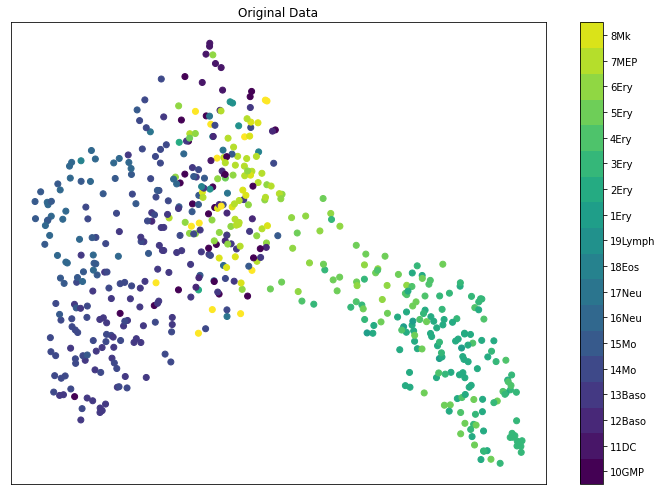

In [ ]:
graph_paul(test_data, original_test_labels, "Original Data", paul_label_encoder)

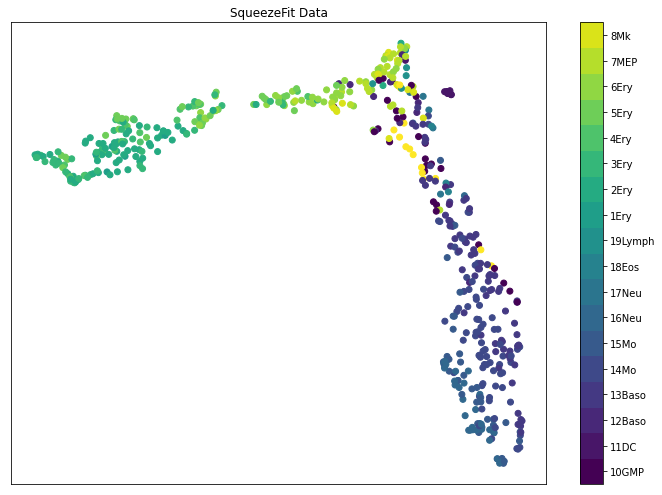

In [ ]:
graph_paul(test_data[:, sc_markers], original_test_labels, "SqueezeFit Data", paul_label_encoder)

# the kink could be an artifact similar to PCA

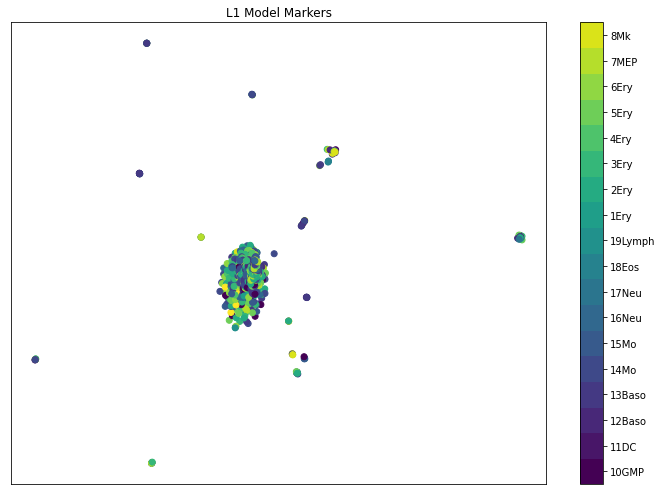

In [ ]:
graph_paul(test_data[:, inds_l1], original_test_labels, "L1 Model Markers", paul_label_encoder)

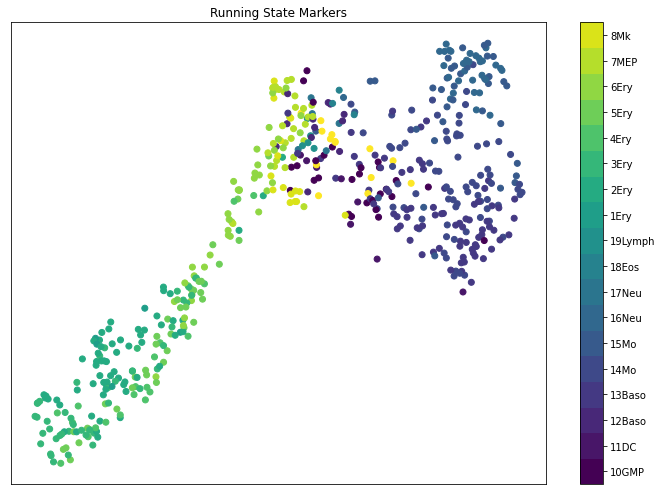

In [ ]:
graph_paul(test_data[:, inds_running_state], original_test_labels, "Running State Markers", paul_label_encoder)

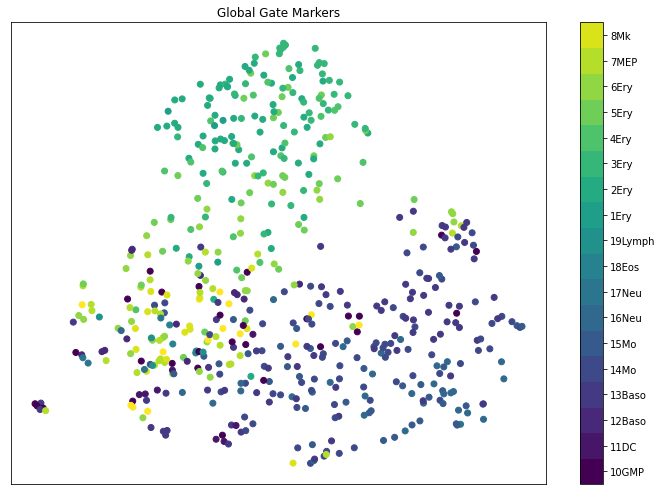

In [ ]:
graph_paul(test_data[:, inds_global_gate], original_test_labels, "Global Gate Markers", paul_label_encoder)

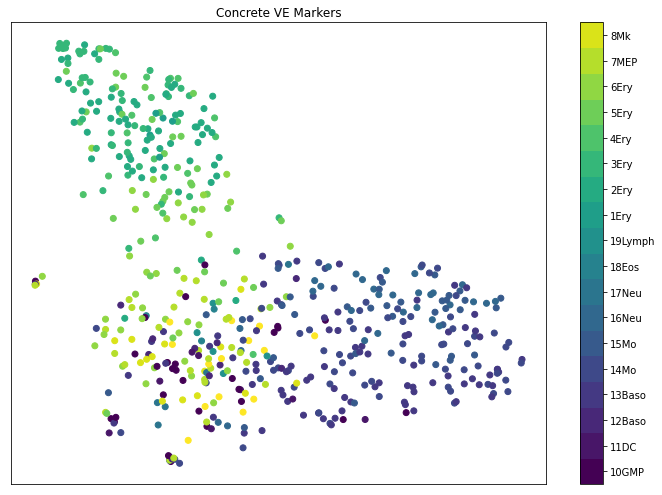

In [ ]:
graph_paul(test_data[:, inds_concrete], original_test_labels, "Concrete VE Markers", paul_label_encoder)